# LJ Toy Implementation Benchmarking

Benchmark runs for various "hypothesis" implementations of a toy 6-12 potential. 

Types:

* Naive: A pure-torch implementation.
* Serial/Parallel CPU: Numba-jit on cpu w/wo parallel kernel.
* Cuda: Numba-jit on cuda.
* Cuda-Preorg: Numba-jit on cuda, pre-organizing numba inputs via "as_cuda_array". Used to estimate launch overhead due to torch/numba type conversion.

In [19]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [20]:
import importlib
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO)

logging.getLogger("rosetta").setLevel(logging.WARNING)

In [21]:
import toolz
from toolz import first

In [22]:
import pyrosetta.distributed

In [23]:
import tmol.tests.data

In [24]:
import tmol.system.io
import tmol.score
import torch

In [25]:
import numba
import numba.cuda
numba.config.NUMBA_NUM_THREADS = 10

In [26]:
import tmol.utility.numba
from tmol.utility.reactive import reactive_attrs, reactive_property

from tmol.tests.benchmark import make_fixture, make_subfixture, stat_frame, subfixture

In [27]:
decoys = tmol.tests.data.structures_bysize()

In [28]:
from matplotlib import pyplot
import seaborn
import pandas

In [29]:
from numba import guvectorize
from numba import float32, float64
import math

import warnings
warnings.filterwarnings("ignore")

In [30]:
@numba.njit
def _lj_impl(a, b):
    delta = (a[0] - b[0],  a[1] - b[1], a[2] - b[2])

    d2 = delta[0] * delta[0] + delta[1] * delta[1] + delta[2] * delta[2]
    
    d6 = d2 * d2 * d2
    d12 = d6 * d6

    return d12 - 2 * d6    

def _lj_jit_kernel(a, b, out):
    for i in numba.prange(a.shape[0]):
        for j in numba.prange(b.shape[0]):
            out[i, j] = _lj_impl(a[i], b[j])
            
    return out

lj_jit_parallel = numba.njit(parallel=True)(_lj_jit_kernel)
lj_jit_serial = numba.njit(parallel=False)(_lj_jit_kernel)

@numba.cuda.jit
def _lj_cjit_kernel(a, b, out):
    i, j = numba.cuda.grid(2)
    if i < a.shape[0] and j < b.shape[1]:
        
        out[i, j] = _lj_impl(a[i], b[j])

In [31]:
%%cython

cimport cython

import numpy
cimport numpy 

@cython.boundscheck(False)
@cython.wraparound(False)
def _cy_lj_kernel(numpy.float32_t[:, :] coords_a, numpy.float32_t[:, :] coords_b, numpy.float32_t[:, :] out):
    cdef int i_m = coords_a.shape[0]
    cdef int j_m = coords_b.shape[0]
    
    for i in range(i_m):
        for j in range(j_m):
            a = coords_a[i]
            b = coords_b[j]
            
            delta = (a[0] - b[0],  a[1] - b[1], a[2] - b[2])

            d2 = delta[0] * delta[0] + delta[1] * delta[1] + delta[2] * delta[2]

            d6 = d2 * d2 * d2
            d12 = d6 * d6

            out[i, j] = d12 - 2 * d6    

In [32]:
def lj_naive(a, b):
    d2 = ((a - b) ** 2).sum(dim=-1)
    
    d6 = d2 * d2 * d2
    d12 = d6 * d6

    lj = (d12  - 2 * d6).sum()

    return float(lj)

In [33]:
import numpy

def benchmark_lj_runs(decoys):
    stats = []
    
    for n, d in decoys.items():
        fixture = make_fixture("lj", stats.append, nres=len(d.tmol_system.residues), natoms=len(d.tmol_coords), model=n)
        
        if fixture.extra_info["nres"] > 600:
            continue
        
        cpu_coords = d.tmol_coords.detach().to("cpu")
        cuda_coords = d.tmol_coords.detach().to("cuda")
        
        bs = (cuda_coords.shape[0],) * 2
        denorm_coords = cuda_coords.expand(bs + (3,)).clone()
        obuf = torch.empty(bs).to("cuda")
        
        n_denorm_coords = numba.cuda.as_cuda_array(denorm_coords)
        n_cuda_coords = numba.cuda.as_cuda_array(cuda_coords)
        n_obuf = numba.cuda.as_cuda_array(obuf)
            
        logging.info(f"{n} res: {len(d.tmol_system.residues)} atoms: {cpu_coords.shape}")
        
        @subfixture(fixture, device="cuda", impl="parallel_jit")
        def jit_cuda():
            out = torch.empty(cuda_coords.shape[:-1] * 2, device=cuda_coords.device)
            
            blocks_per_grid = ((cuda_coords.shape[0] // 32) + 1,) * 2
            threads_per_block = (32,) * 2
            
            _lj_cjit_kernel[blocks_per_grid, threads_per_block](cuda_coords, cuda_coords, out)
            
            return float(out.sum())
        
        @subfixture(fixture, device="cuda", impl="preorg_parallel_jit")
        def preorg_jit_cuda():
            blocks_per_grid = ((cuda_coords.shape[0] // 32) + 1,) * 2
            threads_per_block = (32,) * 2
            
            _lj_cjit_kernel[blocks_per_grid, threads_per_block](n_cuda_coords, n_cuda_coords, n_obuf)
            
            return float(obuf.sum())
        
        @subfixture(fixture, device="cpu", impl="parallel_jit")
        def jit_cpu():
            out = torch.empty(cpu_coords.shape[:-1] * 2)
            
            return float(lj_jit_parallel(cpu_coords.numpy(), cpu_coords.numpy(), out.numpy()).sum())
        
        @subfixture(fixture, device="cpu", impl="serial_jit")
        def jit_cpu_serial():
            out = torch.empty(cpu_coords.shape[:-1] * 2)
            
            return float(lj_jit_serial(cpu_coords.numpy(), cpu_coords.numpy(), out.numpy()).sum())
        
        @subfixture(fixture, device="cuda", impl="naive")
        def naive_cuda():
            a = cuda_coords[None, :, :]
            b = cuda_coords[:, None, :]
            
            lj_naive(a, b)
        
        @subfixture(fixture, device="cpu", impl="naive")
        def naive_cpu():
            a = cpu_coords[None, :, :]
            b = cpu_coords[:, None, :]
            
            return lj_naive(a, b)
        
    return stats

In [34]:
lj_res = benchmark_lj_runs(decoys)

INFO:root:BYSIZE_400_RES_6AZU res: 370 atoms: torch.Size([7176, 3])
INFO:root:BYSIZE_200_RES_5MM8 res: 197 atoms: torch.Size([3600, 3])
INFO:root:BYSIZE_250_RES_5N5G res: 233 atoms: torch.Size([4128, 3])
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:root:BYSIZE_300_RES_6F8B res: 298 atoms: torch.Size([5408, 3])
INFO:root:BYSIZE_100_RES_5UMR res: 97 atoms: torch.Size([1864, 3])
INFO:root:BYSIZE_055_RES_2JWU res: 56 atoms: torch.Size([1080, 3])
INFO:root:BYSIZE_500_RES_5V2D res: 488 atoms: torch.Size([9136, 3])
INFO:root:BYSIZE_040_RES_5UOI res: 43 atoms: torch.Size([816, 3])
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:

In [35]:
dat = stat_frame(lj_res)

dat = pandas.concat(
    (
        dat,
        pandas.merge(
            dat,
            dat.query("name == 'lj.jit_cpu_serial'").groupby("nres").time.mean().rename("serial_cpu_mean").to_frame(),
            left_on="nres",
            right_index=True
        ).eval("time / serial_cpu_mean").rename("serial_cpu_relative")
    ),
    axis=1
)

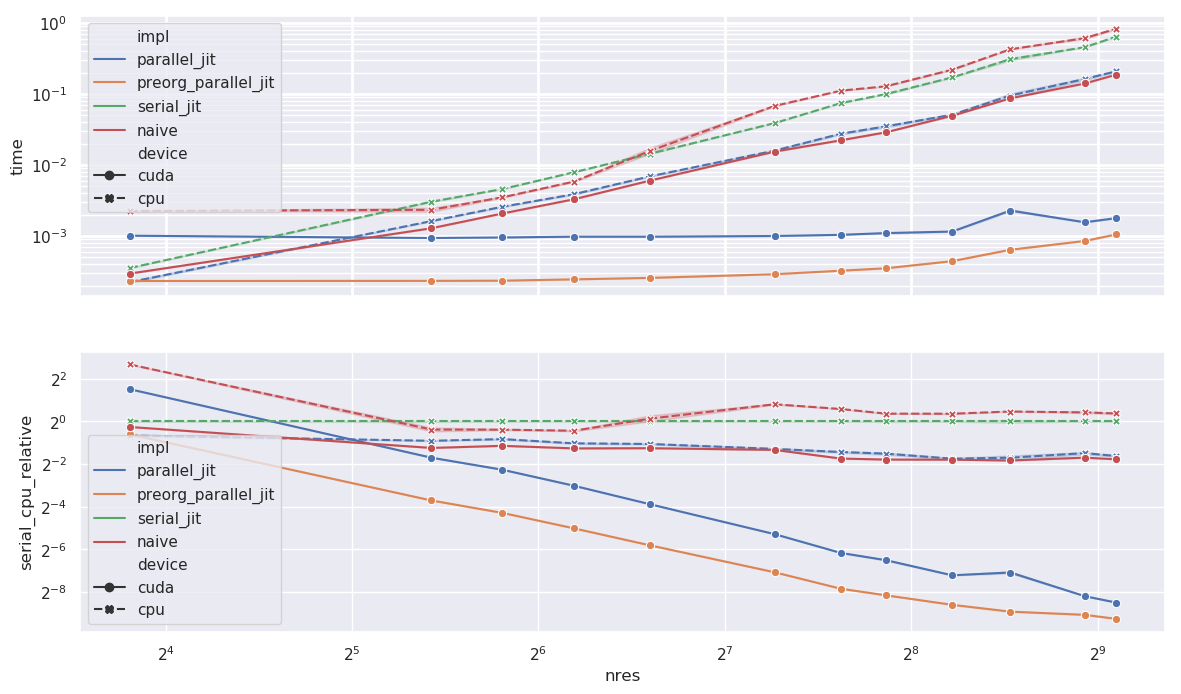

In [36]:
f, (a1, a2) = pyplot.subplots(2, sharex=True)

pyplot.xscale("log", basex=2)

pyplot.sca(a1)
pyplot.yscale("log", basey=10)
pyplot.grid(True, "major", linewidth=2)
pyplot.grid(True, "minor")
seaborn.lineplot("nres", "time", data=dat, hue="impl", style="device", markers=True)

pyplot.sca(a2)
pyplot.yscale("log", basey=2)
seaborn.lineplot("nres", "serial_cpu_relative", data=dat, hue="impl", style="device", markers=True)

In [38]:
dat

,device,impl,model,name,natoms,nres,time,serial_cpu_relative
0,cuda,parallel_jit,BYSIZE_400_RES_6AZU,lj.jit_cuda,7176,370,0.002429,0.007853
1,cuda,parallel_jit,BYSIZE_400_RES_6AZU,lj.jit_cuda,7176,370,0.002262,0.007316
2,cuda,parallel_jit,BYSIZE_400_RES_6AZU,lj.jit_cuda,7176,370,0.002215,0.007164
3,cuda,parallel_jit,BYSIZE_400_RES_6AZU,lj.jit_cuda,7176,370,0.002242,0.007249
0,cuda,preorg_parallel_jit,BYSIZE_400_RES_6AZU,lj.preorg_jit_cuda,7176,370,0.000730,0.002362
1,cuda,preorg_parallel_jit,BYSIZE_400_RES_6AZU,lj.preorg_jit_cuda,7176,370,0.000735,0.002378
2,cuda,preorg_parallel_jit,BYSIZE_400_RES_6AZU,lj.preorg_jit_cuda,7176,370,0.000723,0.002338
3,cuda,preorg_parallel_jit,BYSIZE_400_RES_6AZU,lj.preorg_jit_cuda,7176,370,0.000708,0.002290
4,cuda,preorg_parallel_jit,BYSIZE_400_RES_6AZU,lj.preorg_jit_cuda,7176,370,0.003242,0.010485
5,cuda,preorg_parallel_jit,BYSIZE_400_RES_6AZU,lj.preorg_jit_cuda,7176,370,0.000889,0.002874


In [65]:
(
    dat.query("name=='lj.preorg_jit_cuda'")
    .groupby("nres")[["serial_cpu_relative", "time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
)

mean                           max            \
     serial_cpu_relative      time serial_cpu_relative      time   
nres                                                               
14              0.657469  0.000233            0.846018  0.000300   
43              0.076760  0.000234            0.104150  0.000318   
56              0.051240  0.000235            0.575486  0.002645   
73              0.031068  0.000246            0.035990  0.000285   
97              0.017838  0.000258            0.115817  0.001674   
154             0.007457  0.000290            0.009462  0.000369   
197             0.004367  0.000325            0.039866  0.002969   
233             0.003526  0.000352            0.018673  0.001864   
298             0.002590  0.000444            0.014552  0.002493   
370             0.002075  0.000642            0.011291  0.003492   
488             0.001871  0.000854            0.002122  0.000969   
548             0.001643  0.001053            0.001715  0.001099   

                     std            
     serial_cpu_relative      time  
nres                                
14              0.023102  0.000008  
43              0.002094  0.000006  
56              0.009169  0.000042  
73              0.000700  0.000006  
97              0.001828  0.000026  
154             0.000162  0.000006  
197             0.000700  0.000052  
233             0.000441  0.000044  
298             0.000267  0.000046  
370             0.000521  0.000161  
488             0.000021  0.000010  
548             0.000009  0.000006